# Importazioni e Parametri Globali

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os


Nbins = 200
Nmeasures = 100
base_folder = "/Users/fabianapariti/Downloads/data"
multipoles = ['XI0', 'XI2', 'XI4']
TEST_COVARIANCE = True


# Selezione interattiva della configurazione del test:  si definiscono i valori di sigma e delle scale h da usare nei kernel teorici  in base al tipo di scenario scelto 



In [13]:
print("Seleziona quale test eseguire:")
print("1. Test con sigma costante e scala variabile")
print("2. Test con sigma decrescente e scala costante")
print("3. Test con sigma decrescente e scala piccola")

test = int(input("Inserisci 1, 2 o 3: "))

if test == 1:
    sigma = [0.02, 0.02, 0.02]
    scale_params = [25, 50, 75]
elif test == 2:
    sigma = [0.02, 0.01, 0.005]
    scale_params = [50, 50, 50]
elif test == 3:
    sigma = [0.02, 0.01, 0.005]
    scale_params = [5, 5, 5]
else:
    raise ValueError("Inserimento non valido. Devi scegliere tra 1, 2 o 3.")


Seleziona quale test eseguire:
1. Test con sigma costante e scala variabile
2. Test con sigma decrescente e scala costante
3. Test con sigma decrescente e scala piccola


Inserisci 1, 2 o 3:  1


# Kernel functions e funzione per i grafici
# La matrice è costruita in modo automatico per garantire scalabilità, riutilizzabilità e chiarezza del codice.
Una versione manuale è riportata in fondo al notebook per dimostrare la comprensione completa del modello teorico.


In [15]:
# Kernel functions
def covf(x1, x2, sig, l):
    return sig**2 * np.exp(-(x1 - x2)**2 / (2 * l**2))

def covf1f2(x1, x2, sig1, l1, sig2, l2):
    num = np.sqrt(2 * l1 * l2) * np.exp(-(x1 - x2)**2 / (l1**2 + l2**2)) * sig1 * sig2
    denom = np.sqrt(l1**2 + l2**2)
    return num / denom
# Creazione grafico
def plot_matrix(matrix, title, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(matrix, cmap='viridis')
    plt.colorbar()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# Caricamento dei file FITS contenenti i multipoli (XI0, XI2, XI4) per il test selezionato.
# Per ciascun multipolo si costruisce una matrice (Nbins x Nmeasures) con i dati mock simulati.
 La variabile 'scale' viene letta una sola volta (dal primo file) e usata per tutti i kernel teorici.


In [17]:
folder = os.path.join(base_folder, f"MockMeasures_2PCF_Test{test}")
data_all = []
scale = None

for m in multipoles:
    measures = []
    for i in range(1, Nmeasures + 1):
        fname = os.path.join(folder, f"MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits")
        with fits.open(fname) as file:
            data = file[1].data.copy()
            measures.append(data[m])
            if i == 1 and scale is None:
                scale = data['SCALE']
    data_all.append(np.array(measures).T)

print("Dati caricati correttamente")
print("Esempio matrice XI0:")
print(data_all[0][:5, :5])  # stampa primi 5x5 valori


Dati caricati correttamente
Esempio matrice XI0:
[[8.5420515  8.60360368 8.60682363 8.58966642 8.59925819]
 [2.89127955 2.95350926 2.95753764 2.93882444 2.95015688]
 [1.51079053 1.57357697 1.57834523 1.55798936 1.57114591]
 [0.95832456 1.02154615 1.0269782  1.00490579 1.0199606 ]
 [0.66847166 0.73200672 0.73801938 0.71417031 0.73118736]]


# Calcolo della covarianza di XI0 e confronto con np.cov per verificarne la correttezza.


Calcolo covarianza numerica (manuale vs NumPy)
Differenza max: 3.7947076036992655e-19


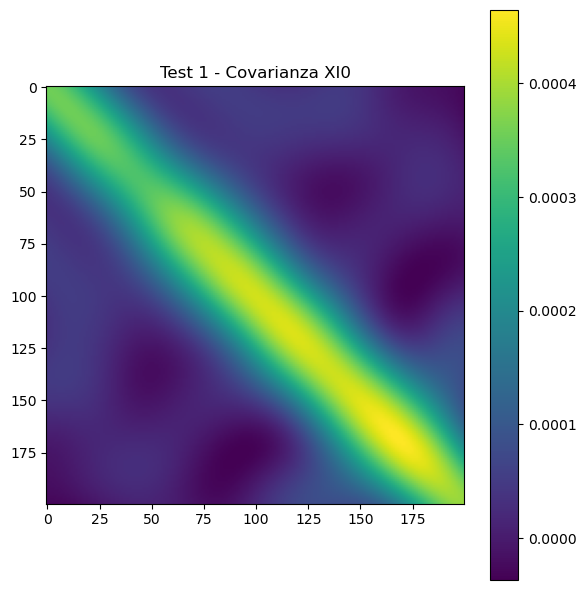

In [25]:
if TEST_COVARIANCE:
    print("Calcolo covarianza numerica (manuale vs NumPy)")
    measures = data_all[0]
    AVE = np.mean(measures, axis=1)
    COV = np.zeros((Nbins, Nbins), dtype=float)

    for i in range(Nbins):
        for j in range(Nbins):
            COV[i, j] = np.sum((measures[i] - AVE[i]) * (measures[j] - AVE[j])) / (Nmeasures - 1)

    cov_xi = np.cov(measures, rowvar=True)
    print("Differenza max:", np.max(np.abs(COV - cov_xi)))
    plot_matrix(cov_xi, f"Test {test} - Covarianza XI0")


# Dopo aver calcolato la covarianza solo per XI0, qui si costruisce la covarianza completa concatenando verticalmente i tre multipoli (XI0, XI2, XI4) in un unico array (full_measures).
 La matrice risultante ha dimensione (3 * Nbins, 3 * Nbins) e include:
 - XI0 nel blocco (0:Nbins, 0:Nbins),
 - XI2 nel blocco (Nbins:2*Nbins, Nbins:2*Nbins),
 - XI4 nel blocco (2*Nbins:, 2*Nbins:).
 I blocchi fuori diagonale rappresentano le cross-covarianze tra multipoli.
 Questa struttura è confrontabile con quella teorica costruita con i kernel.


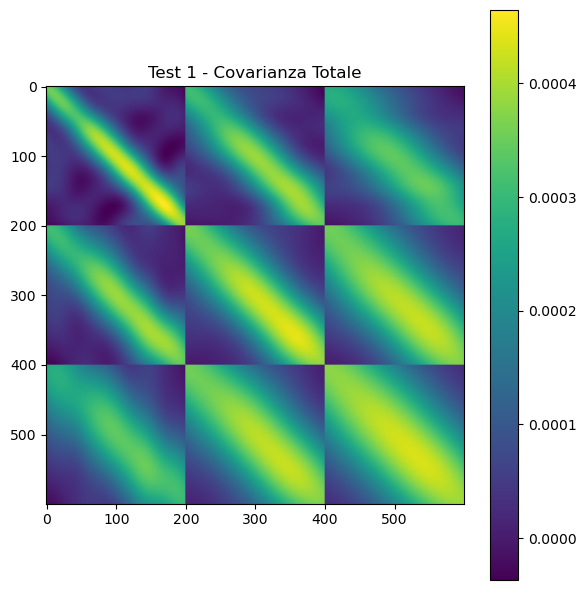

In [27]:
full_measures = np.vstack(data_all)
full_mean = np.mean(full_measures, axis=1)
cov_xi_full = np.cov(full_measures, rowvar=True)
plot_matrix(cov_xi_full, f"Test {test} - Covarianza Totale")


# Costruzione della matrice di correlazione a partire dalla covarianza totale.
 Ogni elemento è normalizzato tra -1 e 1 secondo:
     Corr(i, j) = Cov(i, j) / sqrt(Cov(i,i) * Cov(j,j))
 Questa matrice evidenzia le dipendenze lineari tra i bin, indipendentemente dall’ampiezza assoluta delle varianze.
 La struttura a blocchi rivela anche le correlazioni tra i multipoli (XI0, XI2, XI4).


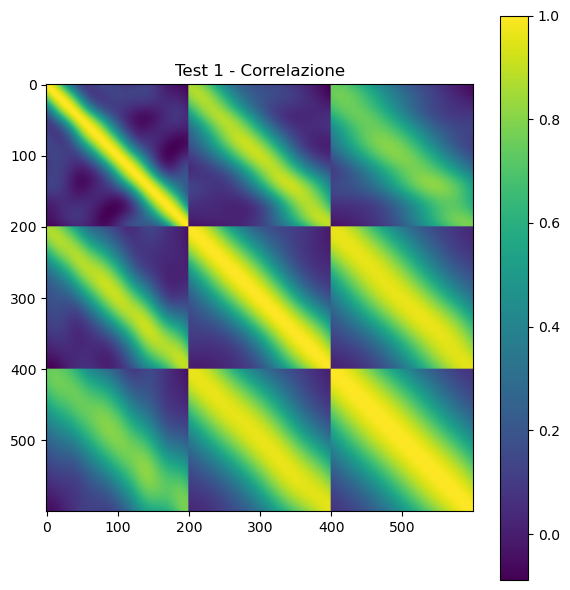

In [29]:
corr_xi = np.zeros_like(cov_xi_full)
for i in range(cov_xi_full.shape[0]):
    for j in range(cov_xi_full.shape[1]):
        denom = np.sqrt(cov_xi_full[i, i] * cov_xi_full[j, j])
        corr_xi[i, j] = cov_xi_full[i, j] / denom if denom > 0 else 0.0

plot_matrix(corr_xi, f"Test {test} - Correlazione")


# Costruzione della matrice teorica completa di covarianza (3*Nbin x 3*Nbin), basata su kernel gaussiani.
 Ogni blocco (i, j) della matrice rappresenta la covarianza tra i multipoli XI{i} e XI{j}:
 - Se i == j: autocovarianza (usando il kernel covf)
 - Se i /= j: cross-covarianza tra multipoli (usando covf1f2)
 La struttura risultante può essere confrontata con la covarianza misurata dai dati mock.


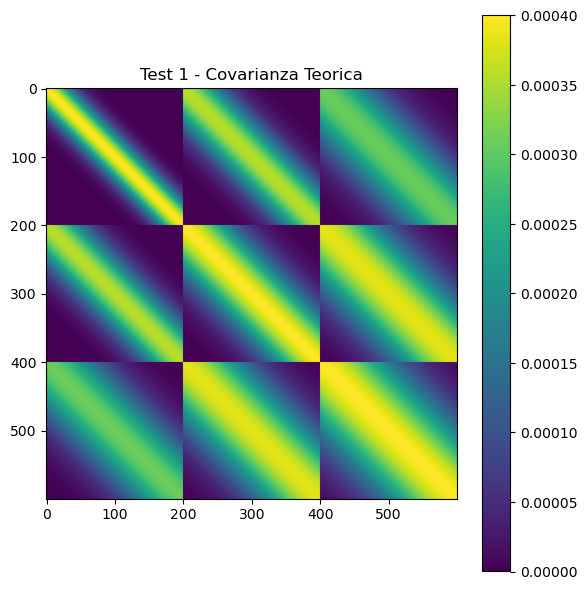

In [31]:
cov_th = np.zeros((3 * Nbins, 3 * Nbins))
for i in range(3):
    for j in range(3):
        for x in range(Nbins):
            for y in range(Nbins):
                I = i * Nbins + x
                J = j * Nbins + y
                if i == j:
                    cov_th[I, J] = covf(scale[x], scale[y], sigma[i], scale_params[i])
                else:
                    cov_th[I, J] = covf1f2(scale[x], scale[y], sigma[i], scale_params[i],
                                           sigma[j], scale_params[j])
plot_matrix(cov_th, f"Test {test} - Covarianza Teorica")


# Calcolo dei residui tra covarianza teorica e misurata, normalizzati per valutare la compatibilità statistica.
# L’RMS finale indica quanto i dati mock si discostano dal modello teorico atteso.


 RMS residui normalizzati per Test 1: 0.447


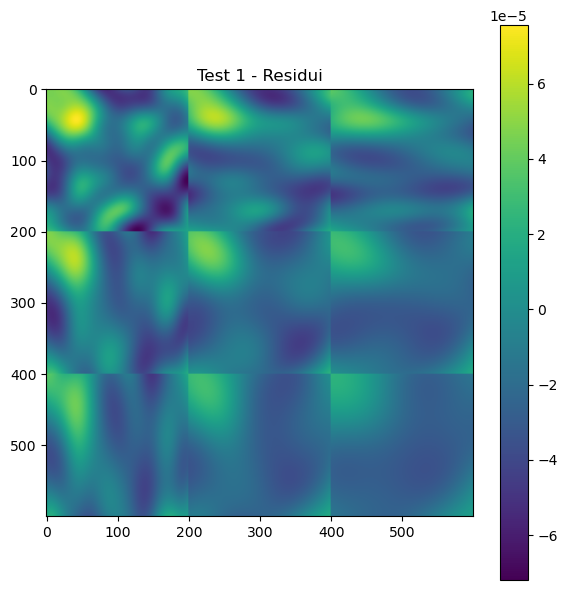

In [33]:
residuals = cov_th - cov_xi_full
norm_residuals = np.zeros_like(residuals)
for i in range(3 * Nbins):
    
    for j in range(3 * Nbins):
        if cov_th[i, i] > 0 and cov_th[j, j] > 0:
            rho2 = (cov_th[i, j])**2 / (cov_th[i, i] * cov_th[j, j])
            norm_residuals[i, j] = residuals[i, j] * np.sqrt((Nmeasures - 1) / ((1 + rho2) * cov_th[i, i] * cov_th[j, j]))

rms_deviation = np.std(norm_residuals.flatten())
print(f"📈 RMS residui normalizzati per Test {test}: {rms_deviation:.3f}")
plot_matrix(residuals, f"Test {test} - Residui")


Risultato finale del test

In [36]:
print("\n===============================")
print(f"RISULTATO FINALE PER TEST {test}")
print("===============================")
status = " OK - PASSATO" if rms_deviation < 1.1 else " Alto - FALLITO"
print(f"{'Test':<10}{'RMS Residui':>15}")
print(f"{test:<10}{rms_deviation:>15.3f}  {status}")



RISULTATO FINALE PER TEST 1
Test          RMS Residui
1                   0.447   OK - PASSATO


# === DIMOSTRAZIONE: costruzione manuale della matrice teorica ===
tutto il codice precedente è automatizzato e modulare,
qui sotto mostro come si può costruire direttamente a mano una matrice di covarianza,
per esempio il blocco XI0 e i blocchi incrociati XI0-XI2 e XI0-XI4,
concludo con un confronto con le vecchie matrici




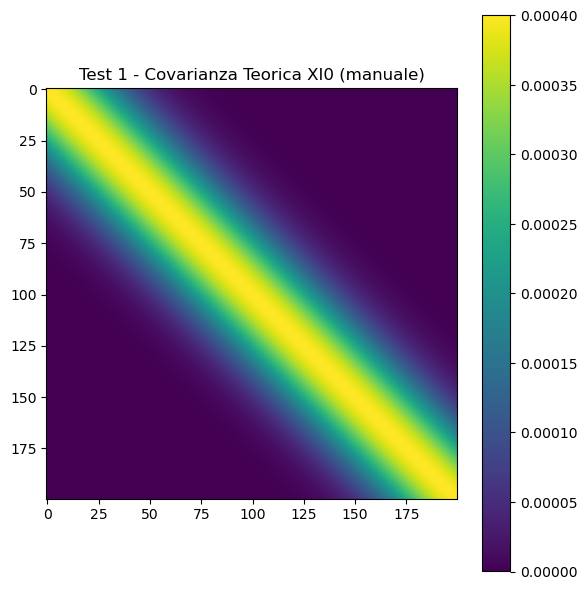

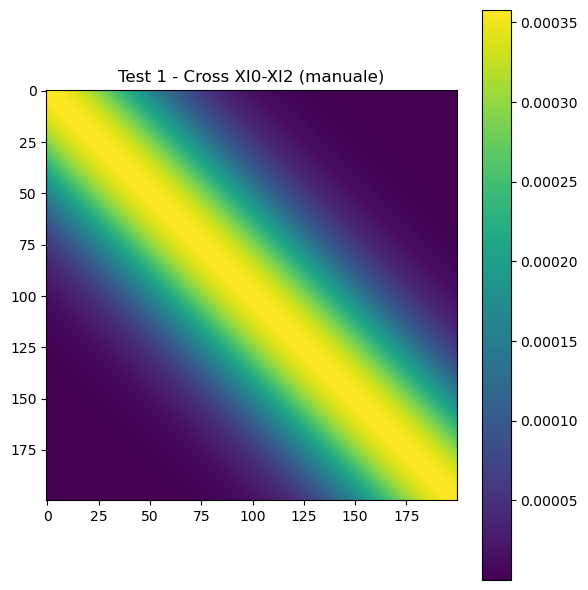

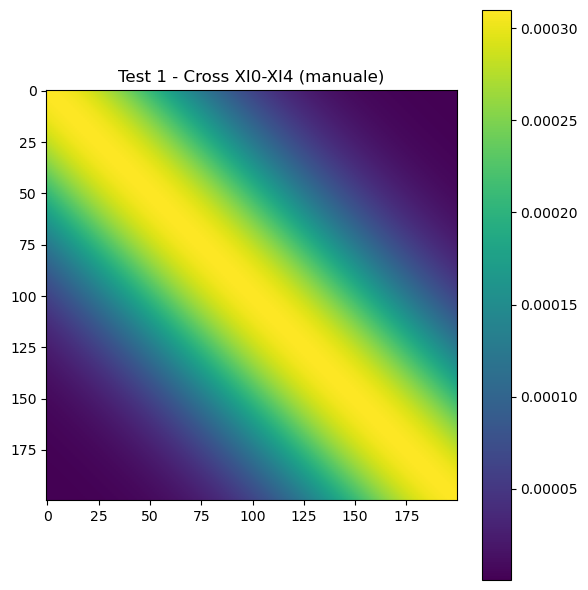

Differenze massime (manuale vs automatica):
  XI0: 0.0
  XI0-XI2: 1.0842021724855044e-19
  XI0-XI4: 1.0842021724855044e-19


In [38]:

# Parametri per XI0, XI2, XI4
sigma_0, sigma_2, sigma_4 = sigma
h_0, h_2, h_4 = scale_params

# Covarianza XI0 (autocovarianza)
Cth_manual_XI0 = np.zeros((Nbins, Nbins), dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        if sigma_0 == 0:
            Cth_manual_XI0[i, j] = 0
        else:
            Cth_manual_XI0[i, j] = sigma_0**2 * np.exp(-(scale[i] - scale[j])**2 / (2 * h_0**2))

# Covarianza XI0-XI2 (cross)
Cth_manual_XI0_XI2 = np.zeros((Nbins, Nbins), dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        if sigma_0 == 0 or sigma_2 == 0:
            Cth_manual_XI0_XI2[i, j] = 0
        else:
            prefactor = sigma_0 * sigma_2 * np.sqrt(2 * h_0 * h_2 / (h_0**2 + h_2**2))
            exponent = - (scale[i] - scale[j])**2 / (h_0**2 + h_2**2)
            Cth_manual_XI0_XI2[i, j] = prefactor * np.exp(exponent)

# Covarianza XI0-XI4 (cross)
Cth_manual_XI0_XI4 = np.zeros((Nbins, Nbins), dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        if sigma_0 == 0 or sigma_4 == 0:
            Cth_manual_XI0_XI4[i, j] = 0
        else:
            prefactor = sigma_0 * sigma_4 * np.sqrt(2 * h_0 * h_4 / (h_0**2 + h_4**2))
            exponent = - (scale[i] - scale[j])**2 / (h_0**2 + h_4**2)
            Cth_manual_XI0_XI4[i, j] = prefactor * np.exp(exponent)


plot_matrix(Cth_manual_XI0, f"Test {test} - Covarianza Teorica XI0 (manuale)")
plot_matrix(Cth_manual_XI0_XI2, f"Test {test} - Cross XI0-XI2 (manuale)")
plot_matrix(Cth_manual_XI0_XI4, f"Test {test} - Cross XI0-XI4 (manuale)")

# Confronto con blocchi della cov_th
print("Differenze massime (manuale vs automatica):")
print("  XI0:", np.max(np.abs(Cth_manual_XI0 - cov_th[0:Nbins, 0:Nbins])))
print("  XI0-XI2:", np.max(np.abs(Cth_manual_XI0_XI2 - cov_th[0:Nbins, Nbins:2*Nbins])))
print("  XI0-XI4:", np.max(np.abs(Cth_manual_XI0_XI4 - cov_th[0:Nbins, 2*Nbins:])))
